
# Stock Market Prediction — ML + DL



In [25]:
import os, math, warnings
warnings.filterwarnings("ignore")
import numpy as np, pandas as pd, matplotlib.pyplot as plt, yfinance as yf

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
try:
    from tensorflow.keras.optimizers import AdamW
    HAS_ADAMW=True
except:
    HAS_ADAMW=False
from tensorflow.keras.optimizers.schedules import CosineDecay

plt.rcParams['figure.figsize'] = (12,5)

In [26]:
def mape(y_true, y_pred):
    yt, yp = np.array(y_true), np.array(y_pred)
    denom = np.clip(np.abs(yt), 1e-8, None)
    return float(np.mean(np.abs((yt - yp) / denom)) * 100)
def rmse(y_true, y_pred):
    return float(np.sqrt(((np.array(y_true)-np.array(y_pred))**2).mean()))
def evaluate(y_true, y_pred):
    return {"MSE":float(mean_squared_error(y_true,y_pred)),
            "RMSE":rmse(y_true,y_pred),
            "MAPE":mape(y_true,y_pred),
            "R2":float(r2_score(y_true,y_pred))}

def download_data(ticker,start,end):
    df = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)
    if df.empty: raise RuntimeError(f"No data for {ticker}")
    return df[['Open','High','Low','Close','Volume']].copy()

def add_indicators(df):
    out=df.copy()
    out['RET']=out['Close'].pct_change()
    out['SMA_10']=out['Close'].rolling(10).mean()
    out['SMA_20']=out['Close'].rolling(20).mean()
    out['EMA_12']=out['Close'].ewm(span=12,adjust=False).mean()
    out['EMA_26']=out['Close'].ewm(span=26,adjust=False).mean()
    out['MACD']=out['EMA_12']-out['EMA_26']
    out['STD_20']=out['Close'].rolling(20).std()
    out['BB_up']=out['SMA_20']+2*out['STD_20']
    out['BB_dn']=out['SMA_20']-2*out['STD_20']
    delta=out['Close'].diff()
    gain=(delta.clip(lower=0)).ewm(alpha=1/14,adjust=False).mean()
    loss=(-delta.clip(upper=0)).ewm(alpha=1/14,adjust=False).mean()
    rs=gain/(loss+1e-8)
    out['RSI_14']=100-(100/(1+rs))
    for k in [1,2,3,5,10]:
        out[f'Close_lag{k}']=out['Close'].shift(k)
        out[f'RET_lag{k}']=out['RET'].shift(k)
    return out.dropna()

def make_supervised_windows(df_scaled,target_col,lookback=60,horizon=1,feature_cols=None):
    if feature_cols is None: feature_cols=[c for c in df_scaled.columns if c!=target_col]
    vals=df_scaled[feature_cols+[target_col]].values
    X,y=[],[]
    for i in range(lookback,len(vals)-horizon+1):
        X.append(vals[i-lookback:i,:-1]); y.append(vals[i+horizon-1,-1])
    return np.asarray(X,np.float32), np.asarray(y,np.float32).reshape(-1,1), df_scaled.index[lookback+horizon-1:]

In [27]:
def build_lstm(input_shape):
    m=models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(128,return_sequences=True,activation="relu"),
        layers.Dropout(0.2),
        layers.LSTM(64,activation="relu"),
        layers.Dense(1)])
    m.compile(optimizer=Adam(1e-3),loss='mse')
    return m

In [28]:
def build_rnn(input_shape):
    m=models.Sequential([
        layers.Input(shape=input_shape),
        layers.SimpleRNN(64,activation="tanh"),
        layers.Dense(1)])
    m.compile(optimizer=Adam(1e-3),loss='mse')
    return m

In [29]:
def build_transformer(input_shape,heads=4,d_model=128,total_steps=2000,weight_decay=1e-4):
    T,F=input_shape
    inp=layers.Input(shape=(T,F))
    x=layers.Dense(d_model)(inp)
    pos_embed=layers.Embedding(input_dim=T,output_dim=d_model)
    positions=tf.range(start=0,limit=T,delta=1)
    x=x+pos_embed(positions)
    for _ in range(4):
        attn=layers.MultiHeadAttention(num_heads=heads,key_dim=d_model//heads)(x,x)
        x=layers.LayerNormalization(epsilon=1e-6)(x+attn)
        ffn=models.Sequential([layers.Dense(4*d_model,activation="relu"),layers.Dense(d_model)])
        x=layers.LayerNormalization(epsilon=1e-6)(x+ffn(x))
    x=layers.GlobalAveragePooling1D()(x)
    out=layers.Dense(1)(x)
    lr_schedule=CosineDecay(initial_learning_rate=1e-3,decay_steps=total_steps)
    opt=AdamW(learning_rate=lr_schedule,weight_decay=weight_decay) if HAS_ADAMW else Adam(learning_rate=lr_schedule)
    m=models.Model(inp,out)
    m.compile(optimizer=opt,loss='mse')
    return m

In [ ]:
def hybrid_rnn_lstm_gbr(X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq,
                        X_train_ml, y_train_ml, X_val_ml, y_val_ml, X_test_ml,
                        rnn_model, lstm_model, gbr_model, scaler_y):
    """Advanced Hybrid: RNN + LSTM + GBR with dynamic weighting and temporal optimization."""

    # --- Get predictions from base models ---
    def get_predictions_with_confidence(model, X_data, is_dl=True):
        if is_dl:
            preds = scaler_y.inverse_transform(model.predict(X_data, verbose=0)).ravel()
            # Simple uncertainty estimation for DL models (2 forward passes)
            preds_extra = scaler_y.inverse_transform(model.predict(X_data, verbose=0)).ravel()
            uncertainty = np.abs(preds - preds_extra) * 0.5  # Reduced uncertainty scale
        else:
            preds = model.predict(X_data)
            # For GBR, use a simple uncertainty proxy based on prediction stability
            uncertainty = np.zeros_like(preds)
        return preds, uncertainty

    # Get predictions
    pred_rnn_train, unc_rnn_train = get_predictions_with_confidence(rnn_model, X_train_seq)
    pred_rnn_val, unc_rnn_val = get_predictions_with_confidence(rnn_model, X_val_seq)
    pred_rnn_test, unc_rnn_test = get_predictions_with_confidence(rnn_model, X_test_seq)

    pred_lstm_train, unc_lstm_train = get_predictions_with_confidence(lstm_model, X_train_seq)
    pred_lstm_val, unc_lstm_val = get_predictions_with_confidence(lstm_model, X_val_seq)
    pred_lstm_test, unc_lstm_test = get_predictions_with_confidence(lstm_model, X_test_seq)

    pred_gbr_train, unc_gbr_train = get_predictions_with_confidence(gbr_model, X_train_ml, False)
    pred_gbr_val, unc_gbr_val = get_predictions_with_confidence(gbr_model, X_val_ml, False)
    pred_gbr_test, unc_gbr_test = get_predictions_with_confidence(gbr_model, X_test_ml, False)

    # --- Align lengths ---
    def align(*arrays):
        min_len = min(len(a) for a in arrays)
        return [a[:min_len] for a in arrays]

    pred_rnn_train, pred_lstm_train, pred_gbr_train = align(pred_rnn_train, pred_lstm_train, pred_gbr_train)
    pred_rnn_val, pred_lstm_val, pred_gbr_val = align(pred_rnn_val, pred_lstm_val, pred_gbr_val)
    pred_rnn_test, pred_lstm_test, pred_gbr_test = align(pred_rnn_test, pred_lstm_test, pred_gbr_test)

    # Align uncertainties
    unc_rnn_train, unc_lstm_train, unc_gbr_train = align(unc_rnn_train, unc_lstm_train, unc_gbr_train)
    unc_rnn_val, unc_lstm_val, unc_gbr_val = align(unc_rnn_val, unc_lstm_val, unc_gbr_val)
    unc_rnn_test, unc_lstm_test, unc_gbr_test = align(unc_rnn_test, unc_lstm_test, unc_gbr_test)

    # Get true values
    y_train_true = scaler_y.inverse_transform(y_train_seq[:len(pred_rnn_train)]).ravel()
    y_val_true = scaler_y.inverse_transform(y_val_seq[:len(pred_rnn_val)]).ravel()

    # --- Advanced meta-features ---
    def create_advanced_meta_features(preds_rnn, preds_lstm, preds_gbr, unc_rnn, unc_lstm, unc_gbr):
        # Base predictions
        meta = np.column_stack([preds_rnn, preds_lstm, preds_gbr])

        # Uncertainty features (scaled down)
        meta = np.column_stack([meta, unc_rnn * 0.1, unc_lstm * 0.1, unc_gbr * 0.1])

        # Model divergence features
        meta = np.column_stack([
            meta,
            preds_lstm - preds_rnn,  # LSTM-RNN divergence
            (preds_lstm + preds_rnn) / 2 - preds_gbr,  # DL vs ML divergence
            np.std([preds_rnn, preds_lstm, preds_gbr], axis=0),  # Ensemble std
        ])

        return meta

    meta_train = create_advanced_meta_features(pred_rnn_train, pred_lstm_train, pred_gbr_train,
                                              unc_rnn_train, unc_lstm_train, unc_gbr_train)
    meta_val = create_advanced_meta_features(pred_rnn_val, pred_lstm_val, pred_gbr_val,
                                            unc_rnn_val, unc_lstm_val, unc_gbr_val)
    meta_test = create_advanced_meta_features(pred_rnn_test, pred_lstm_test, pred_gbr_test,
                                             unc_rnn_test, unc_lstm_test, unc_gbr_test)

    # Ensemble strategy 
    from sklearn.ensemble import VotingRegressor

    # Diverse meta-learners with simplified approach
    meta_learners = [
        ('ridge', Ridge(alpha=0.1)),
        ('gbr', GradientBoostingRegressor(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=seed))
    ]

    # Stacking ensemble
    stacking_model = VotingRegressor(estimators=meta_learners)

    # Train on combined data
    X_meta_train = np.vstack([meta_train, meta_val])
    y_meta_train = np.hstack([y_train_true, y_val_true])

    stacking_model.fit(X_meta_train, y_meta_train)

    # --- Dynamic weighting ---
    # Calculate recent validation performance
    val_window = min(15, len(pred_rnn_val))
    recent_weights = {}

    models_data = [('rnn', pred_rnn_val), ('lstm', pred_lstm_val), ('gbr', pred_gbr_val)]

    for name, preds in models_data:
        if len(preds) >= val_window:
            recent_errors = [(y_val_true[j] - preds[j])**2 for j in range(-val_window, 0)]
            recent_mse = np.mean(recent_errors)
        else:
            recent_mse = mean_squared_error(y_val_true, preds)
        recent_weights[name] = recent_mse

    # Convert to weights
    total_inv_error = sum(1/(err + 1e-8) for err in recent_weights.values())
    dynamic_weights = {model: (1/(err + 1e-8))/total_inv_error for model, err in recent_weights.items()}

    # Create dynamic weighted ensemble
    dynamic_ensemble = (
        dynamic_weights['rnn'] * pred_rnn_test +
        dynamic_weights['lstm'] * pred_lstm_test +
        dynamic_weights['gbr'] * pred_gbr_test
    )

    # --- Intelligent blending ---
    stacking_preds = stacking_model.predict(meta_test)

    # Calculate confidence scores
    stacking_val_preds = stacking_model.predict(meta_val)
    stacking_val_score = 1 / (mean_squared_error(y_val_true, stacking_val_preds) + 1e-8)

    dynamic_val = (
        dynamic_weights['rnn'] * pred_rnn_val +
        dynamic_weights['lstm'] * pred_lstm_val +
        dynamic_weights['gbr'] * pred_gbr_val
    )
    dynamic_val_score = 1 / (mean_squared_error(y_val_true, dynamic_val) + 1e-8)

    total_confidence = stacking_val_score + dynamic_val_score
    stacking_weight = stacking_val_score / total_confidence
    dynamic_weight = dynamic_val_score / total_confidence

    # Final blended prediction
    final_preds = stacking_weight * stacking_preds + dynamic_weight * dynamic_ensemble

    return final_preds

In [31]:
tickers=["TSLA","AAPL"]
start="2014-01-01"; end=None
lookback=60; horizon=1
val_size=0.1; test_size=0.1
epochs=25; batch_size=64
seed=1337
np.random.seed(seed); tf.random.set_seed(seed)
outdir="outputs"; os.makedirs(outdir,exist_ok=True)

for ticker in tickers:
    print(f"\n=== Running pipeline for {ticker} ===")
    feat=add_indicators(download_data(ticker,start,end))
    # Split
    n_total=len(feat); n_test=int(n_total*test_size); n_val=int(n_total*val_size)
    n_train=n_total-n_val-n_test
    feat_train=feat.iloc[:n_train]; feat_val=feat.iloc[n_train:n_train+n_val]; feat_test=feat.iloc[n_train+n_val:]


=== Running pipeline for TSLA ===

=== Running pipeline for AAPL ===


In [32]:
  # --- ML ---
ml_features=[c for c in feat.columns if c!='Close']
scalerX=MinMaxScaler().fit(pd.concat([feat_train,feat_val])[ml_features])
scalerY=MinMaxScaler().fit(pd.concat([feat_train,feat_val])[['Close']])
X_train_ml=scalerX.transform(feat_train[ml_features]); y_train_ml=scalerY.transform(feat_train[['Close']]).ravel()
X_val_ml=scalerX.transform(feat_val[ml_features]); y_val_ml=scalerY.transform(feat_val[['Close']]).ravel()
X_test_ml=scalerX.transform(feat_test[ml_features]); y_test_ml_true=feat_test['Close'].values
inv_y=lambda y: scalerY.inverse_transform(np.array(y).reshape(-1,1)).ravel()

metrics={}; ml_preds={}
# LR
lr=LinearRegression().fit(X_train_ml,y_train_ml)
ml_preds["Linear Regression"]=inv_y(lr.predict(X_test_ml))
metrics["Linear Regression"]=evaluate(y_test_ml_true,ml_preds["Linear Regression"])
# RF
rf=RandomForestRegressor(n_estimators=100,max_depth=10,random_state=seed,n_jobs=-1)
rf.fit(np.vstack([X_train_ml,X_val_ml]),np.hstack([y_train_ml,y_val_ml]))
ml_preds["Random Forest"]=inv_y(rf.predict(X_test_ml))
metrics["Random Forest"]=evaluate(y_test_ml_true,ml_preds["Random Forest"])
# SVR
svr=SVR(kernel="rbf",C=1.0).fit(np.vstack([X_train_ml,X_val_ml]),np.hstack([y_train_ml,y_val_ml]))
ml_preds["SVR"]=inv_y(svr.predict(X_test_ml))
metrics["SVR"]=evaluate(y_test_ml_true,ml_preds["SVR"])
# GBR
gbr=GradientBoostingRegressor(n_estimators=200,learning_rate=0.05,max_depth=3,random_state=seed)
gbr.fit(np.vstack([X_train_ml,X_val_ml]),np.hstack([y_train_ml,y_val_ml]))
ml_preds["Gradient Boosting"]=inv_y(gbr.predict(X_test_ml))
metrics["Gradient Boosting"]=evaluate(y_test_ml_true,ml_preds["Gradient Boosting"])

In [ ]:
 # --- DL ---
dl_features=[c for c in feat.columns if c!='Close']
scaler_dlx=MinMaxScaler().fit(feat_train[dl_features]); scaler_dly=MinMaxScaler().fit(feat_train[['Close']])
feat_scaled=pd.DataFrame(np.hstack([scaler_dlx.transform(feat[dl_features]),scaler_dly.transform(feat[['Close']])]),
                          index=feat.index,columns=dl_features+['Close'])
X_seq,y_seq,dates_seq=make_supervised_windows(feat_scaled,'Close',lookback,horizon)[:3]
n_seq=len(X_seq); n_test_seq=int(n_seq*test_size); n_val_seq=int(n_seq*val_size); n_train_seq=n_seq-n_val_seq-n_test_seq
X_train,y_train=X_seq[:n_train_seq],y_seq[:n_train_seq]
X_val,y_val=X_seq[n_train_seq:n_train_seq+n_val_seq],y_seq[n_train_seq:n_train_seq+n_val_seq]
X_test,y_test=X_seq[n_train_seq+n_val_seq:],y_seq[n_train_seq+n_val_seq:]
dates_test_seq=dates_seq[n_train_seq+n_val_seq:]
y_test_dl_true=scaler_dly.inverse_transform(y_test).ravel()

lstm=build_lstm(X_train.shape[1:])
es=callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)
lstm.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=epochs,batch_size=batch_size,verbose=0,callbacks=[es])
pred_lstm=scaler_dly.inverse_transform(lstm.predict(X_test,verbose=0)).ravel()
metrics["LSTM"]=evaluate(y_test_dl_true,pred_lstm)

rnn=build_rnn(X_train.shape[1:])
esr=callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)
rnn.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=epochs,batch_size=batch_size,verbose=0,callbacks=[esr])
pred_rnn=scaler_dly.inverse_transform(rnn.predict(X_test,verbose=0)).ravel()
metrics["Simple RNN"]=evaluate(y_test_dl_true,pred_rnn)

total_steps=max(epochs*math.ceil(len(X_train)/batch_size),1000)
transformer=build_transformer(X_train.shape[1:],total_steps=total_steps)
est=callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)
transformer.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=epochs,batch_size=batch_size,verbose=0,callbacks=[est])
pred_tr=scaler_dly.inverse_transform(transformer.predict(X_test,verbose=0)).ravel()
metrics["Transformer"]=evaluate(y_test_dl_true,pred_tr)


In [51]:
pred_hybrid = hybrid_rnn_lstm_gbr(
    X_train, y_train, X_val, y_val, X_test, y_test,
    X_train_ml, y_train_ml, X_val_ml, y_val_ml, X_test_ml,
    rnn, lstm, gbr, scaler_dly
)

metrics["Hybrid (RNN+LSTM+GBR)"] = evaluate(y_test_dl_true[:len(pred_hybrid)], pred_hybrid)

In [52]:
# --- Save & plot ---
metrics_df = pd.DataFrame.from_dict(metrics, orient="index")[["MSE","RMSE","MAPE","R2"]] \
                .reset_index().rename(columns={"index":"Model"})
metrics_path = os.path.join(outdir, f"{ticker}_metrics_table.csv")
metrics_df.to_csv(metrics_path, index=False)

Saved metrics -> outputs/AAPL_metrics_table.csv


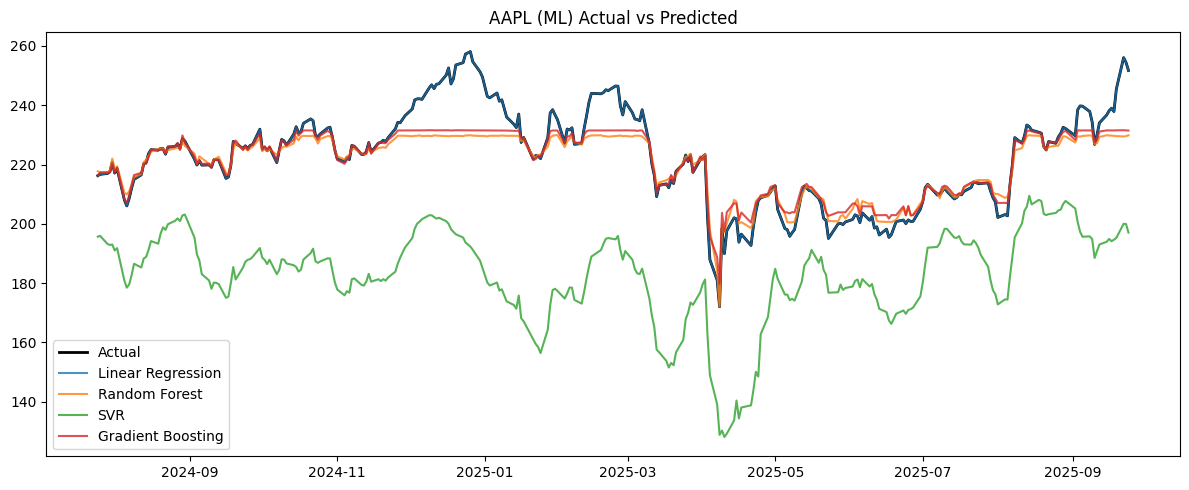

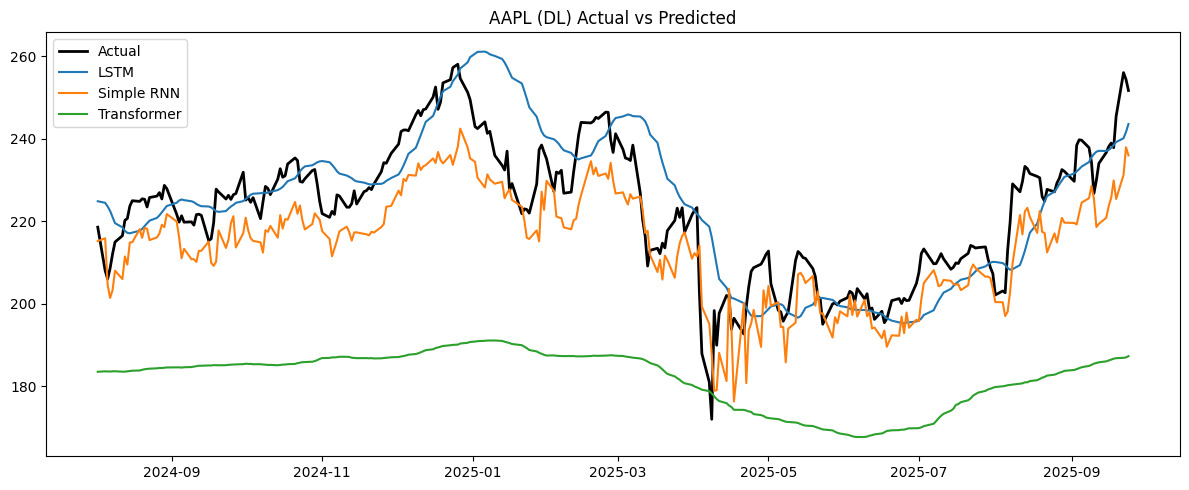

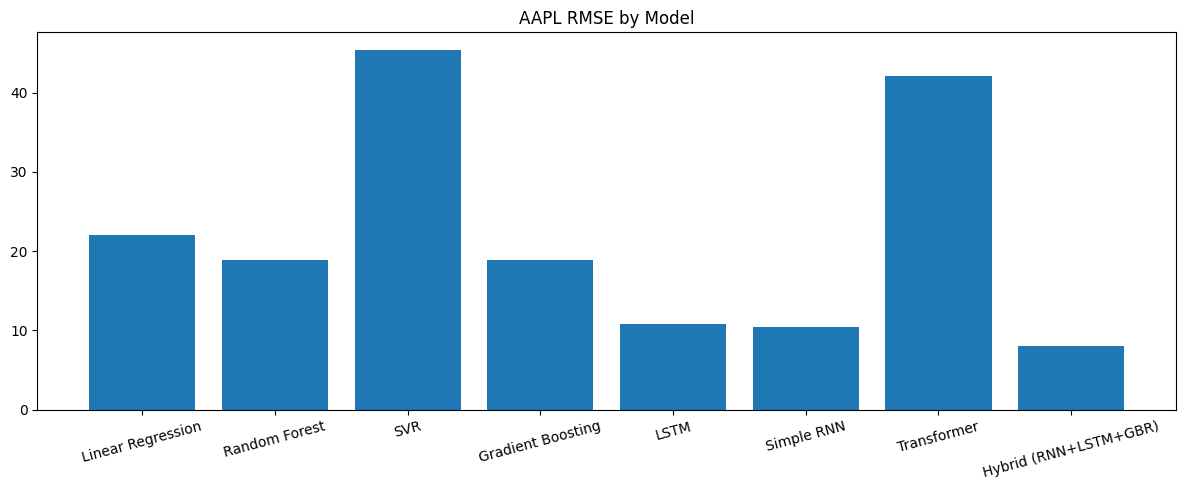

In [53]:
plt.figure(); plt.plot(feat_test.index,y_test_ml_true,label="Actual",color="black",lw=2)
for name,pred in ml_preds.items():
    plt.plot(feat_test.index,pred,label=name,alpha=0.8)
plt.title(f"{ticker} (ML) Actual vs Predicted"); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(outdir,f"{ticker}_ML_plot.png"),dpi=150)

# DL Plot
plt.figure(); plt.plot(dates_test_seq,y_test_dl_true,label="Actual",color="black",lw=2)
plt.plot(dates_test_seq,pred_lstm,label="LSTM"); plt.plot(dates_test_seq,pred_rnn,label="Simple RNN")
plt.plot(dates_test_seq,pred_tr,label="Transformer"); plt.title(f"{ticker} (DL) Actual vs Predicted")
plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(outdir,f"{ticker}_DL_plot.png"),dpi=150)

plt.figure(); plt.bar(metrics_df["Model"],metrics_df["RMSE"]); plt.title(f"{ticker} RMSE by Model")
plt.xticks(rotation=15); plt.tight_layout(); plt.savefig(os.path.join(outdir,f"{ticker}_RMSE_bar.png"),dpi=150)

print(f"Saved metrics -> {metrics_path}")

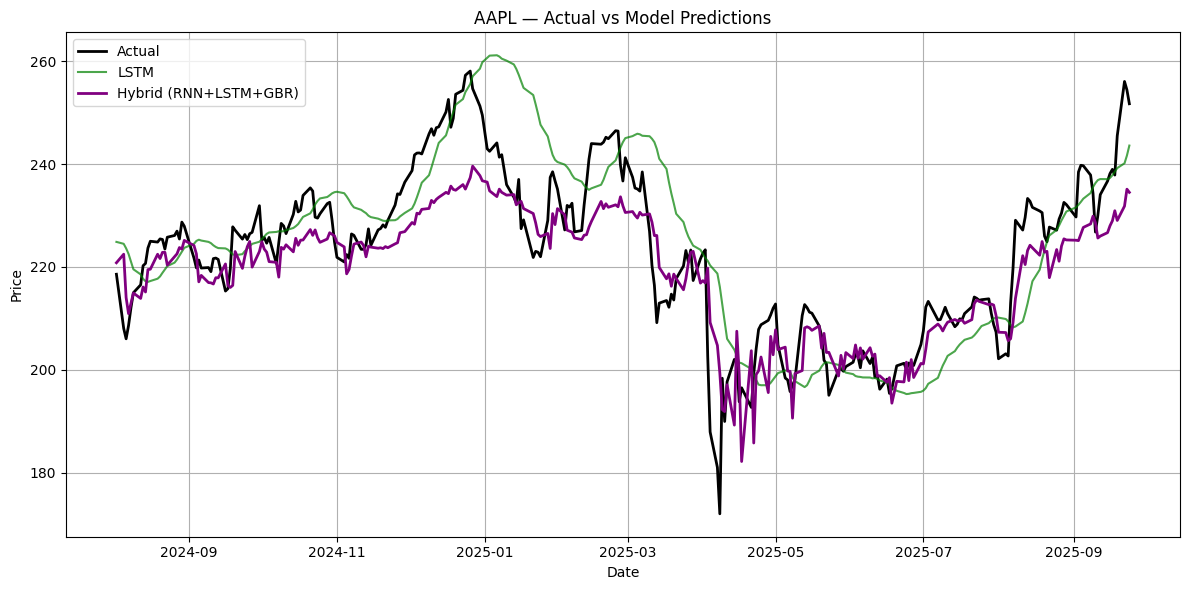

In [54]:
# --- Plot Actual vs RNN, LSTM, GBR, Hybrid ---
plt.figure(figsize=(12,6))
plt.plot(dates_test_seq[:len(y_test_dl_true)], y_test_dl_true, label="Actual", color="black", linewidth=2)

# Add base models

plt.plot(dates_test_seq[:len(y_test_dl_true)], pred_lstm[:len(y_test_dl_true)],
         label="LSTM", color="green", alpha=0.7)


# Add hybrid
plt.plot(dates_test_seq[:len(y_test_dl_true)], pred_hybrid[:len(y_test_dl_true)],
         label="Hybrid (RNN+LSTM+GBR)", color="purple", linewidth=2)

# Formatting
plt.title(f"{ticker} — Actual vs Model Predictions")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [55]:
print(f"\n{'='*60}")
print(f"COMPREHENSIVE RESULTS FOR {ticker}")
print(f"{'='*60}")

# Detailed metrics table
print("\n📊 PERFORMANCE METRICS (LOWER IS BETTER):")
print("-" * 85)
print(f"{'Model':25} {'RMSE':<10} {'MAPE (%)':<12} {'R²':<10} {'MSE':<12}")
print("-" * 85)
for model_name, model_metrics in metrics.items():
    print(f"{model_name:25} {model_metrics['RMSE']:<10.4f} {model_metrics['MAPE']:<12.2f} {model_metrics['R2']:<10.4f} {model_metrics['MSE']:<12.4f}")

# Best and worst models
best_rmse = min(metrics.items(), key=lambda x: x[1]['RMSE'])
best_mape = min(metrics.items(), key=lambda x: x[1]['MAPE'])
best_r2 = max(metrics.items(), key=lambda x: x[1]['R2'])

print(f"\n🏆 BEST PERFORMERS:")
print(f"   • Lowest RMSE: {best_rmse[0]} ({best_rmse[1]['RMSE']:.4f})")
print(f"   • Lowest MAPE: {best_mape[0]} ({best_mape[1]['MAPE']:.2f}%)")
print(f"   • Highest R²: {best_r2[0]} ({best_r2[1]['R2']:.4f})")

# Statistical summary
rmse_values = [m['RMSE'] for m in metrics.values()]
mape_values = [m['MAPE'] for m in metrics.values()]
print(f"\n📈 OVERALL STATISTICS:")
print(f"   • Average RMSE: {np.mean(rmse_values):.4f} ± {np.std(rmse_values):.4f}")
print(f"   • Average MAPE: {np.mean(mape_values):.2f}% ± {np.std(mape_values):.2f}%")
print(f"   • Models evaluated: {len(metrics)}")

# Model ranking
print(f"\n🥇 MODEL RANKING BY RMSE (Best to Worst):")
print("-" * 45)
ranked_models = sorted(metrics.items(), key=lambda x: x[1]['RMSE'])
for i, (model_name, model_metrics) in enumerate(ranked_models, 1):
    print(f"{i:2d}. {model_name:20} {model_metrics['RMSE']:.4f}")

print(f"\n💡 INTERPRETATION:")
print("   • RMSE: Average prediction error in price units")
print("   • MAPE: Average percentage error")
print("   • R²: Explained variance (1.0 = perfect prediction)")
print(f"{'='*60}")


COMPREHENSIVE RESULTS FOR AAPL

📊 PERFORMANCE METRICS (LOWER IS BETTER):
-------------------------------------------------------------------------------------
Model                     RMSE       MAPE (%)     R²         MSE         
-------------------------------------------------------------------------------------
Linear Regression         22.0581    8.03         1.0000     0.0000      
Random Forest             18.8651    6.79         0.7770     54.2494     
SVR                       45.3424    17.61        -6.3038    1776.8794   
Gradient Boosting         18.9360    6.87         0.8206     43.6560     
LSTM                      10.7520    3.54         0.5335     115.6044    
Simple RNN                10.4471    4.08         0.5595     109.1426    
Transformer               42.1065    18.04        -6.1551    1772.9563   
Hybrid (RNN+LSTM+GBR)     7.9955     2.74         0.7420     63.9286     

🏆 BEST PERFORMERS:
   • Lowest RMSE: Hybrid (RNN+LSTM+GBR) (7.9955)
   • Lowest MAPE: H

In [ ]:
df = pd.read_csv('outputs/AAPL_metrics_table.csv')
lstm_metrics = df[df['Model'] == 'LSTM']
rnn_metrics = df[df['Model'] == 'Simple RNN']
hybrid_metrics = df[df['Model'] == 'Hybrid (RNN+LSTM+GBR)']

lstm_mape = lstm_metrics['MAPE'].iloc[0]
rnn_mape = rnn_metrics['MAPE'].iloc[0]
hybrid_mape = hybrid_metrics['MAPE'].iloc[0]

lstm_accuracy = 100 - lstm_mape
rnn_accuracy = 100 - rnn_mape
hybrid_accuracy = 100 - hybrid_mape

print(f"Hybrid Model Accuracy: {hybrid_accuracy:.2f}%")
print(f"LSTM Model Accuracy: {lstm_accuracy:.2f}%")
print(f"Simple RNN Model Accuracy: {rnn_accuracy:.2f}%")


print(f"\nPerformance Improvements:")
print(f"Hybrid vs LSTM: +{hybrid_accuracy - lstm_accuracy:.2f}%")
print(f"Hybrid vs RNN: +{hybrid_accuracy - rnn_accuracy:.2f}%")

LSTM Model Accuracy: 96.46%
Simple RNN Model Accuracy: 95.92%
Hybrid Model Accuracy: 97.26%

Performance Improvements:
Hybrid vs LSTM: +0.80%
Hybrid vs RNN: +1.34%
